In [1]:
# Check if NVIDIA GPU is enabled
!nvidia-smi

Fri Jun  4 01:22:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **CONNECT GOOGLE DRIVE** 

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

Mounted at /content/gdrive
 Classroom			    'My Drive'
'Colab Notebooks'		    'Nathan For You - Frozen Yogurt-1.m4v'
'https:  drive.m.txt'		     trainModel
'images.zip adlı dosyanın kopyası'   yolov3
 library_management_system.zip


# **LOAD DATASET FROM DRIVE**

In [3]:
import os
import zipfile

local_zip = '/mydrive/trainModel/archive.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

# **IMPORT REQUIRED LIBRARIES**

In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
import pickle
import h5py
import sklearn
from sklearn.model_selection import train_test_split
from collections import Counter
import glob
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from random import shuffle
from keras.optimizers import SGD, Adam
import imp
import os
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
%matplotlib inline

# **DATA PREPROCESSING**

I create map_characters variable and assign The Simpsons Characters from dataset with character that have more than 290 pictures.I assign some variable for preprocessing pictures .

In [5]:
map_characters = {0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson', 
        3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
        7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
        11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
        14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'}

pic_size = 64
batch_size = 32
epochs = 200
num_classes = len(map_characters)
pictures_per_class = 1000
test_size = 0.15

I create load pictures function to load pictures from map characters folder and resized them because all pictures should be with the same size for training.

In [6]:
def load_pictures():
    pics = []
    labels = []
    for k, char in map_characters.items():
        pictures = [k for k in glob.glob('/tmp/simpsons_dataset/%s/*' % char)]
        nb_pic = round(pictures_per_class/(1-test_size)) if round(pictures_per_class/(1-test_size))<len(pictures) else len(pictures)

        for pic in np.random.choice(pictures, nb_pic):
            a = cv2.imread(pic)

            a = cv2.resize(a, (pic_size,pic_size))
            pics.append(a)
            labels.append(k)
    return np.array(pics), np.array(labels) 

I split dataset into train and test, I configure pictures content is as float32 and normalize (/255.)

In [7]:
from keras.utils.np_utils import to_categorical

X, y = load_pictures()
y = to_categorical(y, num_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)
dist = {k:tuple(d[k] for d in [dict(Counter(np.where(y_train==1)[1])), dict(Counter(np.where(y_test==1)[1]))]) for k in range(num_classes)}
print('\n'.join(["%s : %d train pictures & %d test pictures" % (map_characters[k], v[0], v[1]) for k,v in sorted(dist.items(), key=lambda x:x[1][0], reverse=True)]))

Train (14317, 64, 64, 3) (14317, 18)
Test (2527, 64, 64, 3) (2527, 18)
lisa_simpson : 1015 train pictures & 161 test pictures
marge_simpson : 1013 train pictures & 163 test pictures
charles_montgomery_burns : 1012 train pictures & 164 test pictures
krusty_the_clown : 1012 train pictures & 164 test pictures
moe_szyslak : 998 train pictures & 178 test pictures
bart_simpson : 997 train pictures & 179 test pictures
ned_flanders : 997 train pictures & 179 test pictures
principal_skinner : 994 train pictures & 182 test pictures
homer_simpson : 992 train pictures & 184 test pictures
milhouse_van_houten : 921 train pictures & 158 test pictures
chief_wiggum : 827 train pictures & 159 test pictures
abraham_grampa_simpson : 779 train pictures & 134 test pictures
sideshow_bob : 725 train pictures & 152 test pictures
apu_nahasapeemapetilon : 527 train pictures & 96 test pictures
kent_brockman : 427 train pictures & 71 test pictures
comic_book_guy : 410 train pictures & 59 test pictures
edna_krabapp

# **TRAINING AND BUILDING NETWORK**

I build network with 4 convolutions using CNN keras model and compile model.

In [8]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        1

I using data augmentation. Because I need to do a number of random variations over the pictures so the model never see the same picture twice. This helps prevent overfitting and helps the model generalize better.

In [10]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=True,  # randomly flip images
            vertical_flip=False)  # randomly flip images
            
datagen.fit(X_train)

I train model for 20 epochs , in mini-batches of 447 samples and fit model to the data using fit the generator.

In [11]:
history = model.fit_generator(datagen.flow(X_train, y_train,
                            batch_size=batch_size),
                            steps_per_epoch=X_train.shape[0] // batch_size,
                            epochs=20,
                            validation_data=(X_test, y_test))

Epoch 1/20
447/447 [==============================] - 63s 43ms/step - loss: 2.6579 - accuracy: 0.2092 - val_loss: 1.4094 - val_accuracy: 0.5880
Epoch 2/20
447/447 [==============================] - 19s 42ms/step - loss: 1.5072 - accuracy: 0.5490 - val_loss: 1.0374 - val_accuracy: 0.6917
Epoch 3/20
447/447 [==============================] - 18s 41ms/step - loss: 1.1590 - accuracy: 0.6538 - val_loss: 0.8672 - val_accuracy: 0.7590
Epoch 4/20
447/447 [==============================] - 18s 41ms/step - loss: 0.9904 - accuracy: 0.7102 - val_loss: 0.7192 - val_accuracy: 0.7982
Epoch 5/20
447/447 [==============================] - 18s 41ms/step - loss: 0.8514 - accuracy: 0.7539 - val_loss: 0.6700 - val_accuracy: 0.7994
Epoch 6/20
447/447 [==============================] - 19s 42ms/step - loss: 0.7909 - accuracy: 0.7656 - val_loss: 0.5908 - val_accuracy: 0.8358
Epoch 7/20
447/447 [==============================] - 19s 43ms/step - loss: 0.7238 - accuracy: 0.7862 - val_loss: 0.7149 - val_accuracy:

# **ANALYZING**

I plot the loss and accuracy of the model over the training and validation data during training.

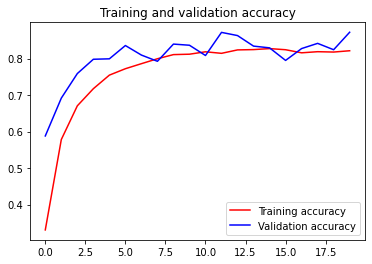

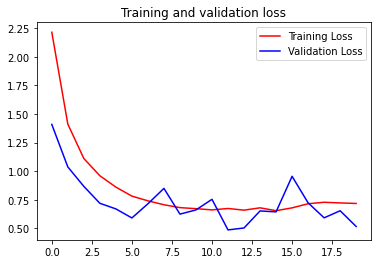

In [12]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **TESTING**

I test the model with using test set I previously splited.

In [13]:
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.82      0.85      0.84       134
  apu_nahasapeemapetilon       0.99      0.91      0.95        96
            bart_simpson       0.67      0.87      0.76       179
charles_montgomery_burns       0.97      0.70      0.81       164
            chief_wiggum       0.94      0.96      0.95       159
          comic_book_guy       0.83      0.85      0.84        59
          edna_krabappel       0.95      0.84      0.89        87
           homer_simpson       0.84      0.79      0.81       184
           kent_brockman       0.75      0.92      0.82        71
        krusty_the_clown       0.90      0.93      0.92       164
            lisa_simpson       0.80      0.73      0.76       161
           marge_simpson       0.96      0.90      0.93       163
     milhouse_van_houten       0.90      0.94      0.92       158
             moe_szyslak       0.88      0.85      0.87       178
        

# **BUILDING DIFFERENT NETWORK AND TRAINING MODEL**

I build network with 6 convolutions using CNN keras model and compile model.

In [14]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same')) 
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

Foremost I train model for 20 epochs , in mini-batches of 447 samples and fit model to the data using fit the generator. but I didn't get good results so I train model again with 10 epochs and I get better results. (I use 20+10 epochs. with 2 epochs I get 0.93 accuracy then I again train model with 10 epochs)


In [16]:
history = model.fit_generator(datagen.flow(X_train, y_train,
                                    batch_size=batch_size),
                                    steps_per_epoch=X_train.shape[0] // batch_size,
                                    epochs=10,
                                    validation_data=(X_test, y_test))

Epoch 1/10
447/447 [==============================] - 18s 39ms/step - loss: 0.2480 - accuracy: 0.9257 - val_loss: 0.1955 - val_accuracy: 0.9470
Epoch 2/10
447/447 [==============================] - 17s 39ms/step - loss: 0.2611 - accuracy: 0.9233 - val_loss: 0.2009 - val_accuracy: 0.9402
Epoch 3/10
447/447 [==============================] - 17s 38ms/step - loss: 0.2409 - accuracy: 0.9292 - val_loss: 0.2121 - val_accuracy: 0.9482
Epoch 4/10
447/447 [==============================] - 18s 39ms/step - loss: 0.2181 - accuracy: 0.9325 - val_loss: 0.1770 - val_accuracy: 0.9557
Epoch 5/10
447/447 [==============================] - 17s 38ms/step - loss: 0.2142 - accuracy: 0.9364 - val_loss: 0.1835 - val_accuracy: 0.9490
Epoch 6/10
447/447 [==============================] - 18s 39ms/step - loss: 0.2257 - accuracy: 0.9314 - val_loss: 0.2218 - val_accuracy: 0.9402
Epoch 7/10
447/447 [==============================] - 18s 39ms/step - loss: 0.2136 - accuracy: 0.9358 - val_loss: 0.2317 - val_accuracy:

# **ANALYZING**

I plot the loss and accuracy of the model over the training and validation data during training.

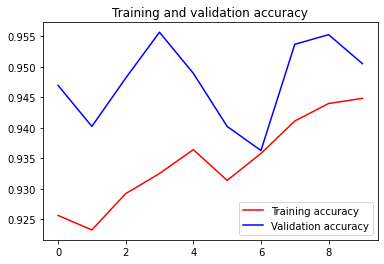

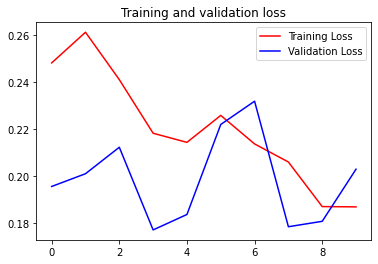

In [17]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **TESTING**

I test the model with using test set I previously splited. I use trained network to generate predictions on new data.

In [18]:
y_pred = model.predict(X_test)
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=list(map_characters.values())), sep='')


                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.96      0.95       134
  apu_nahasapeemapetilon       0.92      1.00      0.96        96
            bart_simpson       0.95      0.94      0.95       179
charles_montgomery_burns       0.97      0.96      0.97       164
            chief_wiggum       0.88      0.98      0.93       159
          comic_book_guy       0.93      0.92      0.92        59
          edna_krabappel       1.00      0.90      0.95        87
           homer_simpson       0.92      0.86      0.89       184
           kent_brockman       0.97      0.96      0.96        71
        krusty_the_clown       0.96      0.96      0.96       164
            lisa_simpson       0.93      0.98      0.95       161
           marge_simpson       0.94      0.98      0.96       163
     milhouse_van_houten       0.97      0.99      0.98       158
             moe_szyslak       0.95      0.89      0.92       178
        

# **PREDICTION**

I create file predict function for predict simpsons characters

In [19]:
def file_predict(image_path, all_perc=False):
    image = cv2.imread(image_path)
    img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    pic = cv2.resize(image, (64,64))
    a = model.predict_proba(pic.reshape(1, 64, 64,3))[0]
    if all_perc:
        print('\n'.join(['{} : {}%'.format(map_characters[i], round(k*100)) for i,k in sorted(enumerate(a), key=lambda x:x[1], reverse=True)]))
    else:
        return map_characters[np.argmax(a)].replace('_',' ').title()

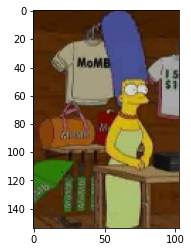

'Marge Simpson'

In [20]:
image_path = "/tmp/kaggle_simpson_testset/kaggle_simpson_testset/marge_simpson_44.jpg"
file_predict(image_path)

# **SAVE AND LOAD MODEL**

In [21]:
model.save_weights("/tmp/model.h5")
model.load_weights('/tmp/model.h5')
print("Loaded model from disk")

Loaded model from disk


I evaluate loaded model it on our test data and print accuarcy.

In [22]:
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
score = model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

accuracy: 95.05%


# **A DIFFERENT WAY TO DATA PREPROCESSING**

Direction of test and train datasets files

In [23]:
data_dir ='/tmp/simpsons_dataset/'
test_dir ='/tmp/kaggle_simpson_testset/kaggle_simpson_testset/'

I get name of files and put them in array

In [24]:
Name=[]
for file in os.listdir(data_dir):
    Name+=[file]

N=[]
for i in range(len(Name)):
    N+=[i]

I take the images in name array and append these to dataset array and create dataset and testset.

In [25]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

dataset=[]
count=0
for name in Name:
    path=os.path.join(data_dir,name)
    for im in os.listdir(path):
        if im[-4:]=='.jpg':
            image=load_img(os.path.join(path,im), grayscale=False, color_mode='rgb', target_size=(100,100))
            image=img_to_array(image)
            image=image/255.0
            dataset.append([image,count])
    count=count+1

In [26]:
testset=[]
for im in os.listdir(test_dir):
    if im[-4:]=='.jpg':
        image=load_img(os.path.join(test_dir,im), grayscale=False, color_mode='rgb', target_size=(100,100))
        image=img_to_array(image)
        image=image/255.0
        testset.append([image,im[0:-4]])

I create numpy array for data and use to_categorical to transform training data before pass it to model.

In [27]:
data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

data=np.array(data)
labels1=to_categorical(labels0)
labels=np.array(labels1)

test=np.array(test)
tlabels=np.array(tlabels0)

I split dataset into train and test

In [28]:
X_train,X_test,ytrain,ytest=train_test_split(data,labels,test_size=0.2,random_state=44)

# **A DIFFERENT WAY TO BUILDING NETWORK AND TRAINING**

A DenseNet is a type of convolutional neural network that utilises dense connections between layers, through Dense Blocks, where we connect all layers (with matching feature-map sizes) directly with each other. To preserve the feed-forward nature, each layer obtains additional inputs from all preceding layers and passes on its own feature-maps to all subsequent layers.

I use DenseNet for build network and create model. I start the network with a Dense layer of size 128 and end the network with a Dense layer of size 43 .The first layer uses a rule activation and the last layer uses a softmax activation.

I compile model.

In [29]:
import tensorflow as tf

premodel = tf.keras.applications.DenseNet201(input_shape=(100,100,3),include_top=False,weights='imagenet',pooling='avg')
premodel.trainable = False

inputs1 = premodel.input
x1 = tf.keras.layers.Dense(128, activation='relu')(premodel.output)
outputs1 = tf.keras.layers.Dense(43, activation='softmax')(x1)
model = tf.keras.Model(inputs=inputs1, outputs=outputs1)
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

74842112/74836368 [==============================] - 1s 0us/step


In [30]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 50, 50, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

I using data augmentation to get better results. 

In [31]:
datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
                        width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")

I train model for 30 epochs , in mini-batches of 524

In [32]:
history = model.fit(datagen.flow(X_train,ytrain,batch_size=32),validation_data=(X_test,ytest),epochs=30)

Epoch 1/30
524/524 [==============================] - 71s 113ms/step - loss: 2.3294 - accuracy: 0.3828 - val_loss: 1.8463 - val_accuracy: 0.5059
Epoch 2/30
524/524 [==============================] - 53s 102ms/step - loss: 1.8193 - accuracy: 0.5102 - val_loss: 1.5755 - val_accuracy: 0.5818
Epoch 3/30
524/524 [==============================] - 56s 106ms/step - loss: 1.6700 - accuracy: 0.5397 - val_loss: 1.4962 - val_accuracy: 0.5966
Epoch 4/30
524/524 [==============================] - 54s 102ms/step - loss: 1.5920 - accuracy: 0.5598 - val_loss: 1.4038 - val_accuracy: 0.6119
Epoch 5/30
524/524 [==============================] - 54s 103ms/step - loss: 1.5314 - accuracy: 0.5745 - val_loss: 1.4359 - val_accuracy: 0.6126
Epoch 6/30
524/524 [==============================] - 58s 111ms/step - loss: 1.5169 - accuracy: 0.5768 - val_loss: 1.4138 - val_accuracy: 0.6059
Epoch 7/30
524/524 [==============================] - 54s 102ms/step - loss: 1.4919 - accuracy: 0.5854 - val_loss: 1.4260 - val_ac

# **ANALYZING**

I plot the loss and accuracy of the model over the training and validation data during training.

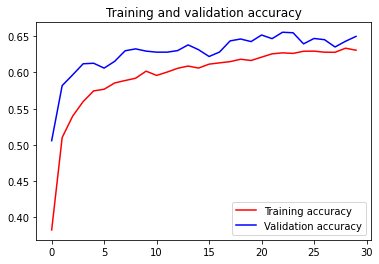

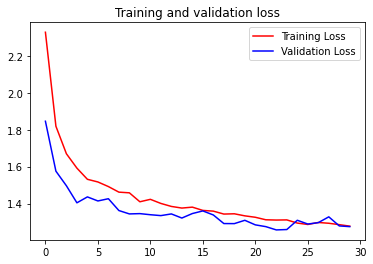

In [33]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()